## Homework5

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### 2.
For a sparse positive definite martix A, if you have a way to find a sparse lower triangle matrix L so that L’AL has much a smaller condition number than A, how would you solve the linear equation Ax=b with Conjugate Gradient method?

我们设 $B = L^T AL$，那么原方程变为：
$$
LBL^T x = b
$$
由于下三角矩阵 $L$ 是稀疏的，因此求解 $Ly = b$ 是非常容易的，随后我们使用共轭梯度法求解：
$$
B(L^T x) = y
$$
$B$ 的条件数很小，所以这个方程依然是可以较容易计算的。最后化为了
$$
L^T x = z
$$
就可以求得$x$的值

#### 3.
Write the functions to achieve 

(1) CG method with a linear search method; 

(2) CG method for linear systems with positive definite matrix.

 Test these algorithms for a few matrix and check the orthogonal properties for the residuals for a large scale linear system.

In [94]:
def line_search(func, alpha, x0, s0, nums):
    """
    在 x0 到 x0 + alpha * s0 直线上进行线搜索
    进行等分线搜索
    """
    points = np.linspace(0, alpha, nums)
    value = [func(x0 + point) for point in points]
    optim_alpha = np.argmin(value); optim_value = value[optim_alpha]
    optim_alpha = points[optim_alpha]
    return optim_alpha, optim_value

def CG_with_line_search(func, dfunc, x0, xstar ,alpha, nums = 200,rho = 0.95, tol = 1e-5, limited_n = 1000, mode = 'Fletcher-Reeves'):
    """ 
    线搜索共轭梯度法
    """
    x0 = np.array(x0); x_his = [x0.tolist()]
    xstar = np.array(xstar); n = 1

    g0 = dfunc(x0); s0 = -g0

    loss = [np.linalg.norm(func(x0)-func(xstar))]
    while loss[-1] > tol:
        optim_alpha, optim_value = line_search(func, alpha * np.linalg.norm(s0), x0, s0 / np.linalg.norm(s0), nums = nums)
        # print(f"{s0[0]=}, {optim_alpha=}")
        x1 = x0 + optim_alpha * s0  / np.linalg.norm(s0)
        
        g1 = dfunc(x1)
        if mode == 'Fletcher-Reeves':
            beta1 = (g1.T @ g1) / (g0.T @ g0) # Fletcher-Reeves
        elif mode == "Polak-Ribiere":
            beta1 = ((g1.T - g0) @ g1) / (g0.T @ g0)
        s0 = -g1 + beta1 * s0
        x0 = x1; g0 = g1
        x_his.append(x0.tolist())
        
        
        if n > limited_n:
            print(f'CG: Iteration has completed {limited_n} times in GD. Stop.')
            break
        loss.append(np.linalg.norm(func(x1)-func(xstar)))
        n += 1
        if n%50 == 1:
            alpha *= rho
    return x1, loss, n, np.array(x_his)  
    
def CG_PDmatrix(A, b, x0, xstar, alpha, rho = 0.95, tol = 1e-5, limited_n = 1000):
    """
    CG 专用解 Ax = b 其中 A 是一个正定矩阵
    """
    x0 = np.array(x0); x_his = [x0.tolist()]; r_his = []
    xstar = np.array(xstar); n = 1
    r0 = (A @ x0 - b); p0 = -r0

    loss = [np.linalg.norm(A @ (x0 - xstar))]
    while loss[-1] > tol:

        optim_alpha = r0.T @ r0 / (p0.T @ A @ p0)
        x1 = x0 + optim_alpha * p0
        r1 = r0 + optim_alpha * A @ p0
        beta0 = r1.T @ r1 / (r0.T @ r0)
        p1 = -r1 + beta0 * p0
        x0 = x1; r0 = r1; p0 = p1
        
        x_his.append(x0.tolist())
        
        if n > limited_n:
            print(f'CG: Iteration has completed {limited_n} times in GD. Stop.')
            break
        loss.append(np.linalg.norm(A @ (x0 - xstar)))
        n += 1
        if n%50 == 1:
            alpha *= rho
    return x1, loss, n, np.array(x_his)        

In [53]:
A = np.random.randn(500,500); A = A.T @ A; 
xstar = np.ones(500)
b = A @ xstar
x1, loss, n, x_his = CG_PDmatrix(A, b, np.zeros(500), xstar, alpha = 1, )
print(f"{loss[-1]=}")

loss[-1]=5.649965302493081e-06


In [95]:
func = lambda x: 1/2 * (x.T @ A @ x) - b.T @ x
dfunc = lambda x: A @ x - b
x2, loss, n, x_his = CG_with_line_search(func, dfunc, np.zeros(500), xstar, alpha = 1, limited_n = 3000)
print(f"{loss[-1]=}")

CG: Iteration has completed 3000 times in GD. Stop.
loss[-1]=54.74502068813308


可见使用 CG_PDmatrix 方法在处理正定矩阵方面确实比普适的线搜索方法要有效地多

#### 4.
 Achieve the interpolants of Runge’s function at equally spaced points.

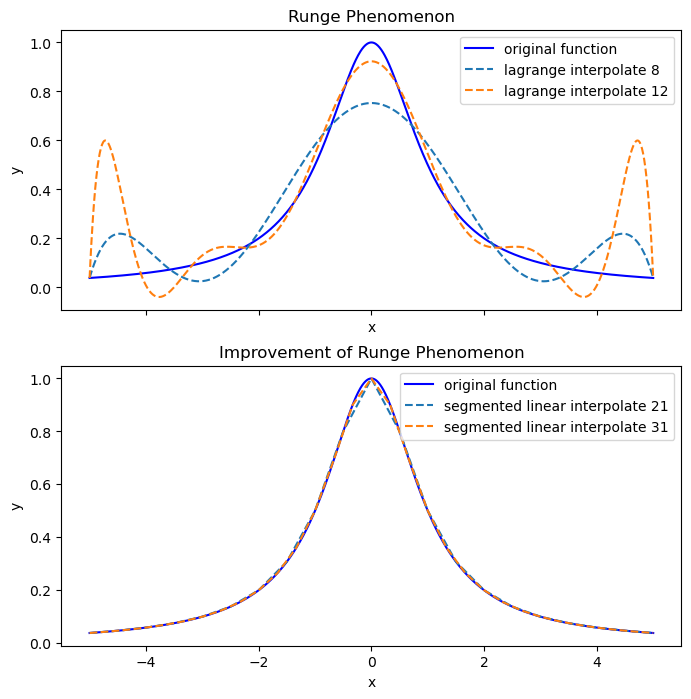

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BarycentricInterpolator
"""定义方程"""
def func(x):
    return 1.0/(1.0+x**2)

"""拉格朗日插值"""
def lagrange(func, degree):
    x = np.linspace(-5,5,degree)
    y = func(x)
    return BarycentricInterpolator(x,y)

"""分段线性插值"""
def segmented_linear_interpolate(func, seg_number):
    x = np.linspace(-5,5, seg_number).T
    y = func(x)
    return x,y

x = np.linspace(-5,5,1000)
y = func(x)
fig, ax =plt.subplots(2,1,sharex= True, figsize = (8,8))
ax[0].set_title('Runge Phenomenon')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_title('Improvement of Runge Phenomenon')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[0].plot(x,func(x),'blue',label = 'original function')
ax[1].plot(x,func(x),'blue',label = 'original function')
# ax[0].plot(x, lagrange(func, 5)(x), '--',label = 'lagrange interpolate 5')
ax[0].plot(x, lagrange(func, 8)(x), '--',label = 'lagrange interpolate 8')
ax[0].plot(x, lagrange(func, 12)(x), '--',label = 'lagrange interpolate 12')
# ax[1].plot(segmented_linear_interpolate(func,11)[0],segmented_linear_interpolate(func,11)[1], '--', label = 'segmented linear interpolate 11')
ax[1].plot(segmented_linear_interpolate(func,21)[0],segmented_linear_interpolate(func,21)[1], '--', label = 'segmented linear interpolate 21')
ax[1].plot(segmented_linear_interpolate(func,31)[0],segmented_linear_interpolate(func,31)[1], '--', label = 'segmented linear interpolate 31')
ax[0].legend()
ax[1].legend()
plt.show()

#### 5.
Write the functions to find the natural cubic spline function using the shooting method and the B-spline method.

下面的代码是使用 B-样条构造自然三次样条的函数。只需要将 B 样条的第一个样条和最后一个样条的阶数为2，其余的阶数均为3，构造出的 B 样条就是自然边界条件的三次样条。

In [25]:
def B_spline(u_list, p_list, k = 3):
    """
    B 样条版本的自然三次样条
	params:
        u_list: 待求坐标
        p_list: 控制点的坐标集，应为一个 m*2 大小的 ndarray; 第一个数值为坐标，第2,3个数值为对应坐标值
        k: B 样条阶数
    return:
        result: 三次 B 样条在待求坐标下的值
	"""
    result = []
    n = len(p_list)
    for u_ind, u in enumerate(u_list):
        x, y = 0, 0
        k_tmp = k - 1 if (u_ind in [0, len(u_list)-1]) else k      
        for i in range(0, n - k - 1):            
            B_ik = deBoor_Cox(u, k_tmp, i, p_list[:,0])
            x += B_ik * p_list[i][1]; y += B_ik * p_list[i][2]
        result.append([x,y])
    return np.array(result)


def deBoor_Cox(u, k, i, p_list):
    """
    返回第 i 个 k 阶 B 样条在 u 点的值; p_list 是控制点集
    """
    if k==0:
        if p_list[i] <= u <= p_list[i+1]:
            return 1
        else:
            return 0
    else:
        coef_1, coef_2 = 0, 0
        if p_list[i+k] - p_list[i] == 0: # 重复节点情况
            coef_1 = 0
        else:
            coef_1 = (u-p_list[i]) / (p_list[i+k]-p_list[i])
        if p_list[i+k+1] - p_list[i+1] == 0: # 重复节点情况
            coef_2 = 0
        else:
            coef_2 = (p_list[i+k+1]-u) / (p_list[i+k+1]-p_list[i+1])
    return coef_1 * deBoor_Cox(u, k-1, i, p_list) + coef_2 * deBoor_Cox(u, k-1, i+1, p_list)

In [29]:
p_list = np.linspace(0,1, 30, endpoint = True)
tmp_p = np.linspace(0, 2*np.pi, 30, endpoint = True)
p_list = np.c_[p_list, tmp_p, np.exp(tmp_p) + np.random.randn(30)*0.05]
k = 3
u_list = np.linspace(0.1,0.9,20)
res_u = B_spline(u_list, p_list, k = k)

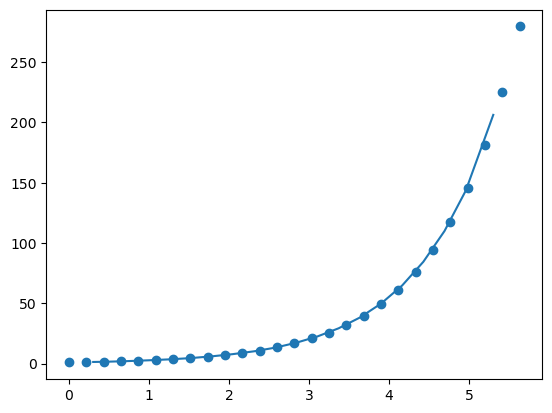

In [31]:
plt.scatter(p_list[:-3,1], p_list[:-3,2])
plt.plot(res_u[:,0], res_u[:,1])